In [1]:
### Inporting required packages
from apscheduler.schedulers.background import BackgroundScheduler
import time
import numpy as np
import pygame
from datetime import datetime, timedelta
from pandas import read_csv

pygame 2.0.1 (SDL 2.0.14, Python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
### Functions
def read_input():
    with open(r'input.txt') as f:
        lines = f.read().splitlines()

    instruments = []
    instrument_paths = []
    velocity_subfolders = []
    velocity_bounds = []
    midi_paths = []

    for i in range(len(lines)):
        if (lines[i][:11] == 'instruments'):
            n_instruments = int(lines[i][11:])
        if (lines[i][:4] == 'name'):
            instruments.append(lines[i][22:])
        if (lines[i][:15] == 'instrument_path'):
            instrument_paths.append(lines[i][22:])
        if (lines[i][:15] == 'velocity_bounds'):
            velocity_bounds.append(lines[i][22:])
        if (lines[i][:19] == 'velocity_subfolders'):
            velocity_subfolders.append(lines[i][22:])
        if (lines[i][:9] == 'midi_path'):
            midi_paths.append(lines[i][22:])

    for i in range(n_instruments):
        velocity_subfolders[i] = velocity_subfolders[i].split(", ")
        velocity_bounds[i] = np.float_(velocity_bounds[i].split(", "))
    return n_instruments, instruments, instrument_paths, velocity_subfolders, velocity_bounds, midi_paths

def note_path(midi_nr, vel, INSTRUMENT):
    """
    Returns the path to the note sound file. The function assumes the sound files have been sepparated in dictonaries based on the velocity of the velocity (loudness).
    The midi_nr is assumed to be withing the typical  range of [23, 108] and the velocity is assumed to be within a range of [0, 127]
    """
    for i in range(len(INSTRUMENT.velocity_bounds)-1):
        if (midi_nr <= 108 and midi_nr >= 23):
            if (vel <= INSTRUMENT.velocity_bounds[i+1]):
                return INSTRUMENT.instrument_paths+INSTRUMENT.velocity_subfolders[i]+"/" + str(midi_nr) + ".wav"
        else: 
            print("warning note missing")
            return -99

def player(Note, Volume,n):
    if (Note!=-99):
        channel = pygame.mixer.Channel(n)
        effect = pygame.mixer.Sound(Note)
        channel.set_volume(Volume)
        channel.play(effect)
    return 

def make_recipe(midicsv_path, INSTRUMENT, play_all_instruments = False, BPM_override = None):
    """
    Interprets midicsv files (midi files which have been converted to csv) and turns them into a recipe which can be played via the play recipe function.
    
    Parameters
    ----------
    midicsv_path : string
        Either a local or a global path to the csv file. When using an input.txt file all defined midicsv paths can be loaded into a list with read_input()[5].
    INSTRUMENT: instance
        An instrument instance created using the Instrument class. This instance is required to filter instrument notes and since the Instrument is passed on to the play_recipe() function as part of the recipe.
    play_all_instruments : boolean, optional
        If set to True, all playable notes will be played regardless if the instrument type fits.
    BPM_override : number, optional
        BPM_override can be used to force a different BPM (play speed) of what was specified in de midicsv file.
        
    Returns recipe
    --------------
    song : pandas DataFrame 
        A dataframe with the midicsv data, Ie instrument number, note time, "channel", midi number and the velocity (loudness).
    multi : Number
        Multiplier used for the play speed.
    INSTRUMENT : instance
        The instance as used as input.
    """
    # Reading CSV file
    song = read_csv(midicsv_path, skipinitialspace=True,usecols=np.arange(6),header=None,skiprows=0, encoding='ISO-8859-1')
    
    # Estimating play speed multiplier based on midicsv input unless BPM_override is not None
    if (BPM_override != None):
        BPS = BPM_override/60
    else:
        BPS = 1e6/float(song[np.logical_or(song.iloc[:,2] == " Tempo", song.iloc[:,2] == "Tempo")].iloc[0,3])
    print("BPM = "+str(round(BPS*60,1)))
    multi = (read_csv(midicsv_path,usecols=np.arange(6),skiprows = 0,header=None,nrows=1).iloc[0,-1]*BPS)

    # Checking what midicsv instruments match with the input instrument
    instruments = song[song.iloc[:,2] == "Program_c"]
    i_play = [] # list of matching notes
    for i in range(len(instruments)):
        if any(float(instruments.iloc[i,4]) == INSTRUMENT.midi_instrument_nrs):
            i_play.append(instruments.iloc[i,0])

    # Selecting the notes of only the active instruments unless play_all_instruments==True
    if (play_all_instruments==False):
        song = song[[song.iloc[i,0] in i_play for i in range(len(song))]]
        print("playing "+str(len(i_play))+" out of "+str(len(instruments))+" instruments")
    else:
        print("playing "+str(len(instruments))+" out of "+str(len(instruments))+" instruments")
        
    # Removing currently unused midicsv file lines such as changes in playspeed
    song = song[np.logical_or(song.iloc[:,2]=="Note_on_c", song.iloc[:,2]=="Note_off_c")] # Selecting only playing commands
    return song, multi, INSTRUMENT

def play_recipe(recipe,velocity_volume=True, echo_time = None):
    """
    Plays the notes according to the recipes using the player function. 
    
    Parameters
    ----------
    recipe : tuple
        A tuple created by the make_recipe() function. A recipe contains a song Pandas DataFrame and a multi(plyer) scaler and an instrument instance.
    velocity_volume: bolean
        A True/False switch which determines wether the individual note volume should scale linearly with the velocity. If not given, then True will be used.
    echo_time: number, optional
        Abruptly stopping key presses after a fixed amount of time. Can be used to free up channels or for a staccato effect. If not given, then None will be used, which means wavs are played as long as possible.
    
    See Also
    --------
    make_recipe : A function used to make receipes
    Instrument : A class which can be used to create INSTRUMENT instances

    Example
    -------
    >>> play_recipe(make_recipe(midicsv_paths[0]),Instrument(read_input(),0))
    """
    vol = 1
    song, multi, INSTRUMENT = recipe
    pygame.mixer.init()
    pygame.init()

    scheduler = BackgroundScheduler()
    timenow = datetime.now()

    channel_note = [[None,None],[None,None]]
    free_channels = list(np.arange(8))
    
    notes = np.array(song.iloc[:,4])
    vels = np.array(song.iloc[:,5])
    
    for i in range(len(song)):
        note = int(notes[i])
        vel = int(vels[i])
        if (velocity_volume):
            vol = vel/np.max(vels)
        if any(np.array(channel_note)[:,1] == note):
            free_channels.insert(0,np.array(channel_note)[np.array(channel_note)[:,1] == note][0][0])
            channel_note.remove(channel_note[int(np.where(np.array(channel_note)[:,1] == note)[0])])
        if len(free_channels) == 0:
            free_channels.append(channel_note[2][0])
        channel_note.append([int(free_channels[0]),note])

        if echo_time != None:
            if vel != 0:
                scheduler.add_job(player, 'date',[note_path(note,int(vel),INSTRUMENT),vol,free_channels[0]], run_date=timenow + timedelta(seconds=int(song.iloc[i,1])/multi),misfire_grace_time=3,max_instances=8)
            else:
                scheduler.add_job(player, 'date',[note_path(note,int(vel),INSTRUMENT),vol,free_channels[0]], run_date=timenow + timedelta(seconds=int(song.iloc[i,1])/multi+echo_time),misfire_grace_time=3,max_instances=8)
        else:
            if vel != 0:
                scheduler.add_job(player, 'date',[note_path(note,int(vel),INSTRUMENT),vol,free_channels[0]], run_date=timenow + timedelta(seconds=int(song.iloc[i,1])/multi),misfire_grace_time=3,max_instances=8)
        free_channels = free_channels[1:]
    scheduler.start()
    input('Press enter to stop: ')
    scheduler.shutdown()

def true_or_false(string):
    """
    Function used for command line yes or no input. Takes either y/n and converts it into True of False output.
    """
    if (string == "Yes" or string == "yes" or string == "Y" or string == "y"):
        return True
    elif (string == "No" or string == "no" or string == "n" or string == "N"):
        return False
    else:
        print("try again")
        true_or_false(input())
        
def is_int(integer):
    """
    Function used to check if input is an integer.
    """
    try: 
        int(integer)
        return int(integer)
    except ValueError:
        print("try again")
        is_int(input())

In [6]:
### Classes
class Instrument:
    """
    Create instrument class.
    input_txt = input_txt function output
    i = instrument number
    """
    def __init__(self,input_txt,instr_i):
        instr_nr_combinations = (
            ['piano',np.arange(8)],
            ['blank',np.arange(0)]
        )
        self.name = input_txt[1][instr_i]
        self.instrument_paths = input_txt[2][instr_i]
        self.velocity_subfolders = input_txt[3][instr_i]
        self.velocity_bounds = input_txt[4][instr_i]
        for i in range(len(instr_nr_combinations)):
            if (self.name == instr_nr_combinations[i][0]):
                self.midi_instrument_nrs = instr_nr_combinations[i][1]

In [7]:
if __name__ == "__main__":
    keep_playing = True
    while keep_playing:
        play_all_instruments = true_or_false(input("Play all instruments? y/n")) # plays all notes regardless of what instrument it is supposed to be played on 
        csv_nr = int(is_int(input("Song number: ")) - 1)

        INSTRUMENTS = [Instrument(read_input(),i) for i in range(read_input()[0])]
        midicsv_paths = read_input()[5]
        play_recipe(make_recipe(midicsv_paths[csv_nr],INSTRUMENTS[0]))
        keep_playing = true_or_false(input("Keep playing? y/n"))

Play all instruments? y/n n
Song number:  1


BPM = 200.0
playing 2 out of 3 instruments


Press enter to stop:  
Keep playing? y/n n


In [ ]:
### Input
# path = "midicsv-1.1/Tetris Theme.csv"
# path = "midicsv-1.1/Billy_Joel_-_Piano_Man.csv"
# path = "midicsv-1.1/for_elise_by_beethoven.csv"
# path = "midicsv-1.1/deb_prel.csv"
# path = "midicsv-1.1/Henry Mancini - Pink Panther.csv"
# path = "midicsv-1.1/Beethoven-Moonlight-Sonata.csv"
# path = "midicsv-1.1/Sia - Elastic Heart.csv"
# path = "midicsv-1.1/Pirates of the Caribbean - He's a Pirate.csv"
# path = "midicsv-1.1/joe_hisaishione_summers_day.csv"
# path = "midicsv-1.1/pachelbel_canon.csv"

# Wav file analyses

In [61]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [611]:
midi_nr = 40
max_fr = 4200*2
samplerate, data = wavfile.read(note_path(midi_nr, 60, 0))

yf = (fft(data[:,0])[:int(len(fft(data[:,0]))/2)])
xf = (fftfreq(len(data[:,0]), 1 / samplerate)[:len(yf)])
yf = yf[xf<=max_fr]
xf = xf[xf<=max_fr]

loglogyf = np.real(np.log(np.log(yf)))
normloglogyf = (loglogyf-np.min(loglogyf))/np.max(loglogyf-np.min(loglogyf))

peak_index = list(normloglogyf).index(np.max(normloglogyf))
bounds = 0.9, 0.915

second_peak_data = []
mode = 0
count = 0
for j in range(2):
    for i in range(len(xf)):
        if (mode == 0):
            if (normloglogyf[peak_index+i] < bounds[1]):
                mode = 1
                
        if (mode == 1):
            count += 1
            if (count >= 400):
                mode = 2
                
        if (mode == 2):
            if (int(peak_index+i)>=len(normloglogyf)):
                break
            if (normloglogyf[peak_index+i] > bounds[1]):
                second_peak_data.append([xf[peak_index+i],normloglogyf[peak_index+i]])
            if (second_peak_data != []):
                if (normloglogyf[peak_index+i] < bounds[0]):
                    second_peak_data = np.array(second_peak_data)
                    break

    if (len(second_peak_data) == 0):
        bounds = bounds[0]-.1,bounds[1]-.1
    else:
        break
        
second_peak_index = list(second_peak_data[:,1]).index(np.max(second_peak_data[:,1]))
fr_found = second_peak_data[second_peak_index,0] - xf[peak_index]

if (fr_found<10):# high tones don't resonated clearly therefore they are estimated based on the peak frequency
    fr_found = xf[peak_index]
index = read_csv('C:/Users/ianmu/OneDrive - Delft University of Technology/Google Drive/Overig/Overig/midi_nr_names.csv').iloc[:,0]
frs = read_csv('C:/Users/ianmu/OneDrive - Delft University of Technology/Google Drive/Overig/Overig/midi_nr_names.csv').iloc[:,5]

midi_nr_est = int(index[list(np.abs(frs - fr_found)).index(np.min(np.abs(frs - fr_found)))])

midi_nr_est

40

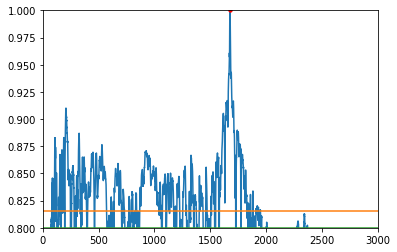

In [589]:
plt.plot(xf, normloglogyf)
plt.xlim(0,3000)
plt.ylim(0.8,1)
plt.plot([0,3000],[bounds[1],bounds[1]])
plt.plot([0,3000],[bounds[0],bounds[0]])
plt.plot(xf[peak_index],np.real(normloglogyf)[peak_index],'r.')
plt.plot(second_peak_data[second_peak_index,0],second_peak_data[second_peak_index,1],'r.')


In [558]:
midi_nr

24